In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Get the training and testing instances 
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv') # these are the testing instances without label

In [4]:
# Add a feature counting number of years away from a median year released
median_yr_train = train_df['title_year'].median()
median_yr_test = test_df['title_year'].median()
train_df['years_from_median'] = train_df['title_year'] - median_yr_train
test_df['years_from_median'] = test_df['title_year'] - median_yr_test

In [5]:
# Separate features and class labels in the training set
X = train_df.drop('imdb_score_binned', axis=1)
y = train_df['imdb_score_binned']

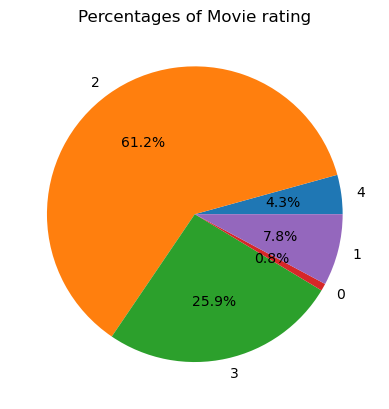

In [380]:
# Exploring the distribution of classes
label_counter = Counter(y)
labels = list(label_counter.keys())
counts = list(label_counter.values())

# Plotting a pie chart with labels and their percentages
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Percentages of Movie rating')
plt.show()

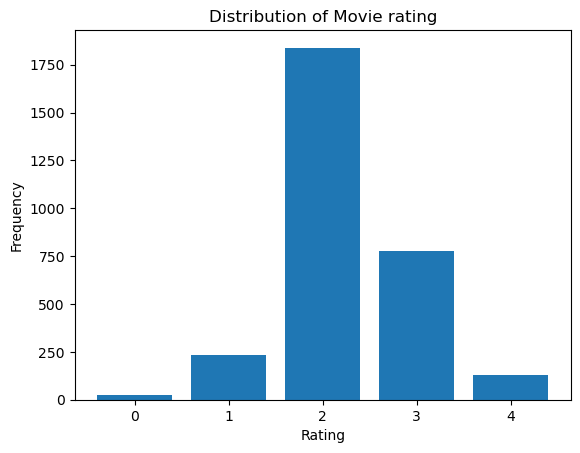

In [381]:
plt.bar(labels, counts)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie rating')
plt.show()

In [382]:
# Identify the numerical columns in the dataset, including the movie rating
numerical_columns = ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes',
                     'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 
                     'facenumber_in_poster', 'num_user_for_reviews', 'years_from_median', 'actor_2_facebook_likes', 
                     'movie_facebook_likes', 'average_degree_centrality', 'imdb_score_binned']
X_num = train_df[numerical_columns]

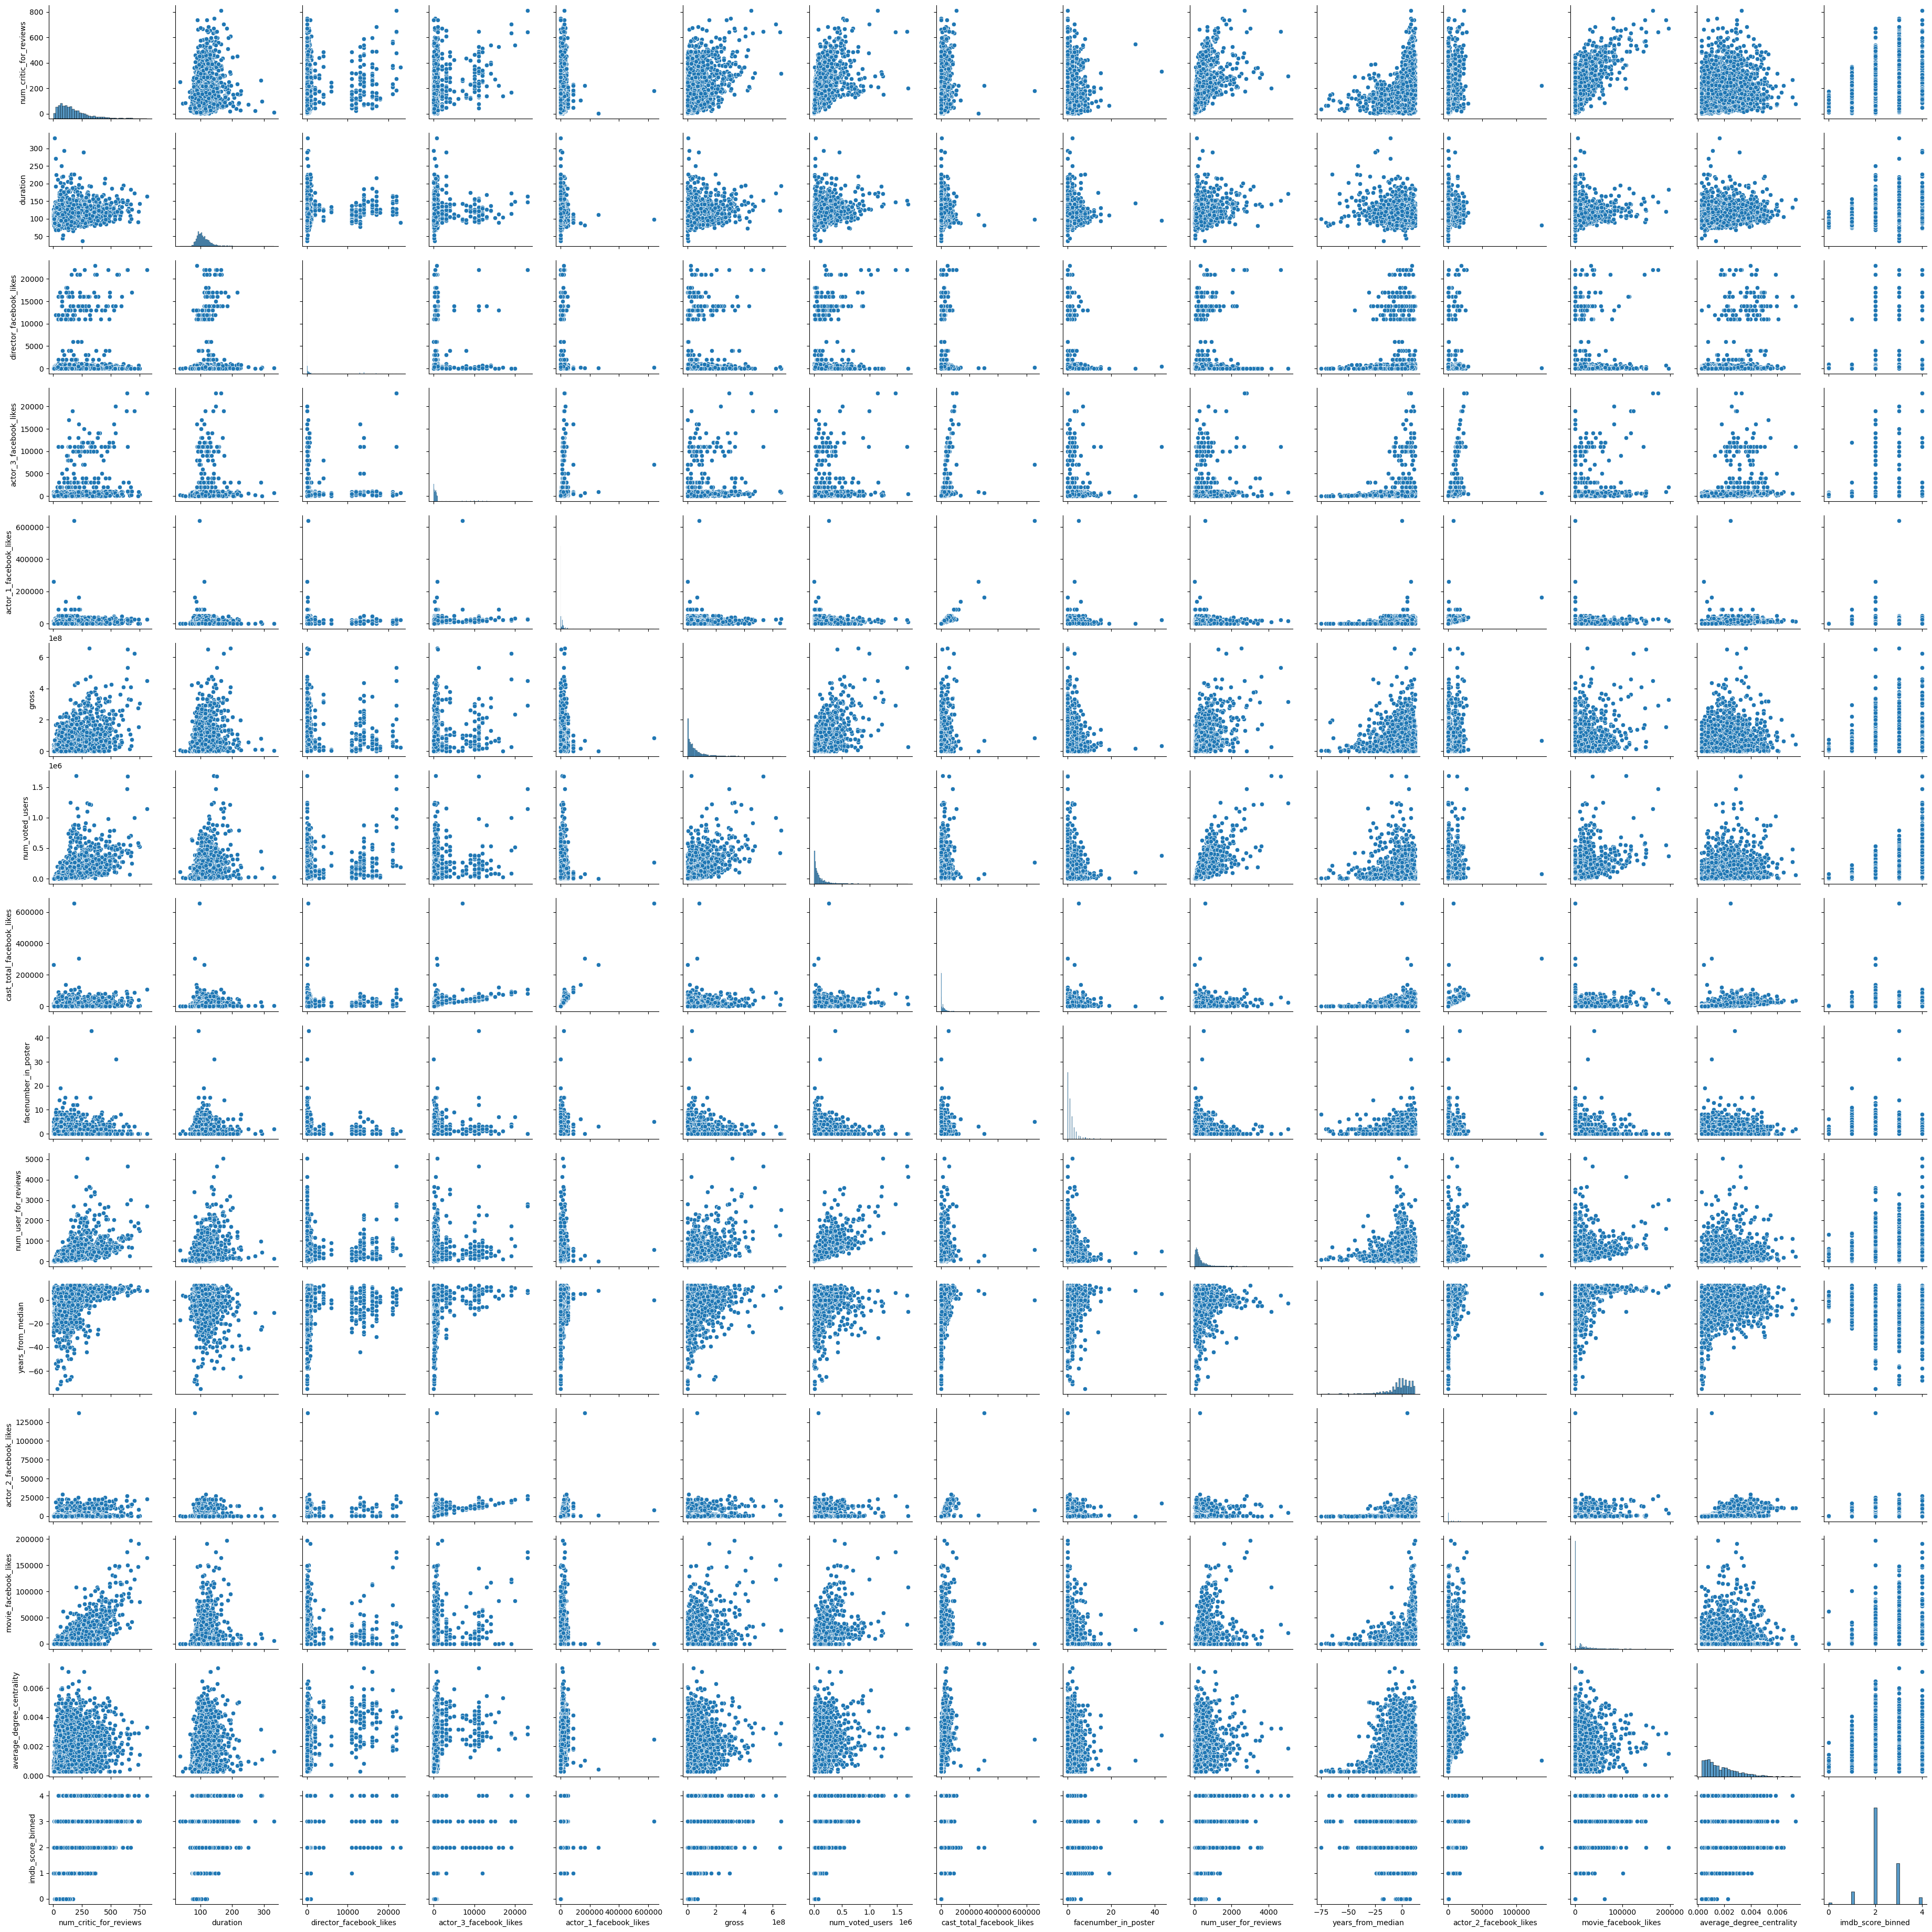

In [383]:
# Draw a pair plot of all the numerical columns to observe any relationships
sns.pairplot(X_num)
plt.show()

In [384]:
def scatter_plot(df, feature_x, feature_y, title):

    # Take a subset of 200 training instances and split into low and high quality
    df_sample = df.sample(n=200, random_state=42)
    
    for label in labels:
        rows_of_label = df_sample[(df_sample['imdb_score_binned'] == label)]
        feature1 = rows_of_label[feature_x]
        feature2 = rows_of_label[feature_y]
        plt.scatter(feature1, feature2, s=15, label=str(label))

    # Add axis labels and titles
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(title)
    plt.legend()

    plt.show()

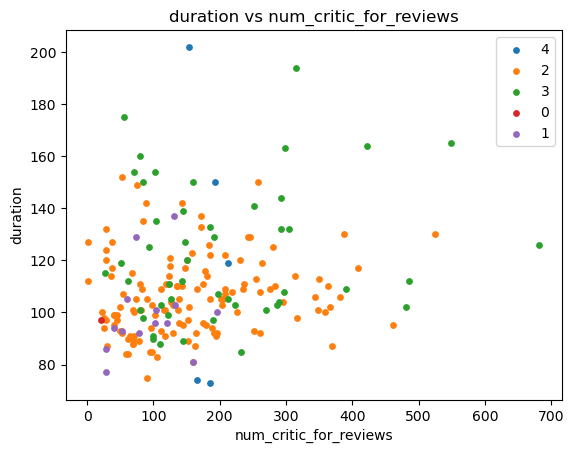

In [385]:
scatter_plot(X_num, 'num_critic_for_reviews', 'duration', title="duration vs num_critic_for_reviews")

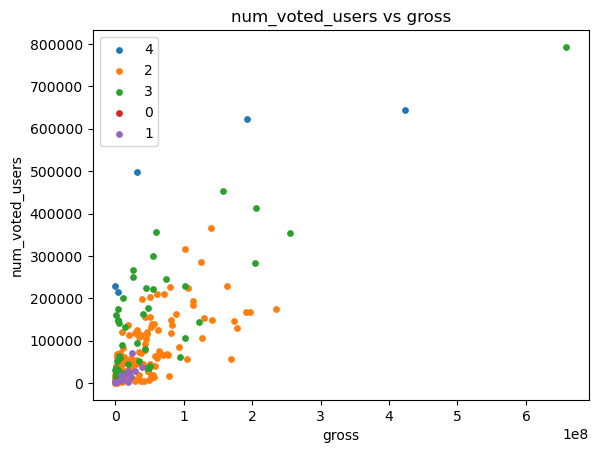

In [386]:
scatter_plot(X_num, 'gross', 'num_voted_users', title="num_voted_users vs gross")

In [6]:
# Drop facenumber_in_poster and identify the remaining numerical features
numerical_features = ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 
                      'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 
                      'num_user_for_reviews', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality',
                      'years_from_median']

# Identify the categorical features 
categorical_features = ['language', 'country', 'content_rating']

# Combine the numerical and categorical features' columns
num_categorical = numerical_features + categorical_features
train_num_categorical = train_df[num_categorical]
test_num_categorical = test_df[num_categorical]

# Prepare a single preprocessor that does scaling and One Hot Encoding
preprocessor = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), numerical_features),
    ('categorical',  OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')

In [398]:
# Implementing 0R as baseline model
zero_r = DummyClassifier(strategy='most_frequent')
start_time = time.time()
zero_r.fit(X, y)
end_time = time.time()
training_runtime = end_time - start_time
print("Training Runtime: {:.4f} seconds".format(training_runtime))

# 5-fold cross-validation for 0R
print("Average 5-fold cross-validation mean accuracy of baseline (0R):", np.mean(cross_val_score(zero_r, X, y, cv=5)))

Training Runtime: 0.0616 seconds
Average 5-fold cross-validation mean accuracy of baseline (0R): 0.6121841375485302


In [425]:
# Predict the testing instances
start_time = time.time()
zr_pred = zero_r.predict(test_df)
end_time = time.time()
prediction_runtime = end_time - start_time
print("Prediction Runtime: {:.4f} seconds".format(prediction_runtime))

# Save 0R results to a CSV file
zr_submission = pd.DataFrame({'id': test_df['id'], 'imdb_score_binned': zr_pred})
zr_submission.to_csv('0R_results.csv', index=False)

Prediction Runtime: 0.0497 seconds


In [444]:
# Create a pipeline for Random Forest including the preprocessor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [430]:
# Hyperparameter tuning for Random Forest using GridSearchCV
rf_param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [None, 10, 20]
}
# Start searching for the best hyperparameters
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_num_categorical, y)
rf_best_params = grid_search.best_params_
print("Best Parameters for Random Forest:", rf_best_params)

Best Parameters for Random Forest: {'classifier__max_depth': None, 'classifier__n_estimators': 200}


In [431]:
# Train Random Forest with the best parameters on numerical features
best_rf = grid_search.best_estimator_
start_time = time.time()
best_rf.fit(train_num_categorical, y)
end_time = time.time()
training_runtime = end_time - start_time
print("Training Runtime: {:.4f} seconds".format(training_runtime))

# Find 5-fold cross-validation average accuracy
print("Average 5-fold cross-validation accuracy of Random Forest:", np.mean(cross_val_score(best_rf, train_num_categorical, y, cv=5)))

Training Runtime: 11.1717 seconds
Average 5-fold cross-validation accuracy of Random Forest: 0.7167138103161398


In [432]:
# Predict movie ratings of test instances using Random Forest
start_time = time.time()
rf_pred = best_rf.predict(test_num_categorical)
end_time = time.time()
prediction_runtime = end_time - start_time
print("Prediction Runtime: {:.4f} seconds".format(prediction_runtime))

rf_submission = pd.DataFrame({'id': test_df['id'], 'imdb_score_binned': rf_pred})
rf_submission.to_csv('RF_results.csv', index=False)

Prediction Runtime: 0.1674 seconds


In [440]:
# Create a pipeline for Bagging ensemble of Decision Trees including the preprocessor
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))
])

In [441]:
# Hyperparameter tuning for Bagging ensemble of Decision Trees using GridSearchCV
bagging_param_grid = {
    'classifier__n_estimators': [50, 100, 150], 
    'classifier__max_samples': [0.7, 0.8, 0.9],  
    'classifier__max_features': [0.7, 0.8, 0.9], 
    'classifier__base_estimator__max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(estimator=bagging_pipeline, param_grid=bagging_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_num_categorical, y)
bagging_best_params = grid_search.best_params_
print("Best Parameters for Bagging ensemble of Decision Trees:", bagging_best_params)

Best Parameters for Bagging ensemble of Decision Trees: {'classifier__base_estimator__max_depth': 20, 'classifier__max_features': 0.8, 'classifier__max_samples': 0.9, 'classifier__n_estimators': 150}


In [442]:
# Train Bagging classifier with the best parameters on both numerical and categorical features
best_bagging = grid_search.best_estimator_
start_time = time.time()
best_bagging.fit(train_num_categorical, y)
end_time = time.time()
training_runtime = end_time - start_time
print("Training Runtime: {:.4f} seconds".format(training_runtime))
print("Average 5-fold cross-validation accuracy of Bagging Decision Tree:", np.mean(cross_val_score(best_bagging, train_num_categorical, y, cv=5)))

Training Runtime: 30.5215 seconds
Average 5-fold cross-validation accuracy of Bagging Decision Tree: 0.7303616195230173


In [443]:
# Predict movie ratings using Bagging Decision Tree
start_time = time.time()
bagging_pred = best_bagging.predict(test_num_categorical)
end_time = time.time()
prediction_runtime = end_time - start_time
print("Prediction Runtime: {:.4f} seconds".format(prediction_runtime))

bagging_submission = pd.DataFrame({'id': test_df['id'], 'imdb_score_binned': bagging_pred})
bagging_submission.to_csv('Bagging_results.csv', index=False)

Prediction Runtime: 0.4010 seconds


In [9]:
# THIS IS A PRELIMINARY EXPERIMENT FOR BAGGING WITH NO HYPERPARAMETER TUNING
bagging_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, 
                                       random_state=42)

bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', bagging_classifier)
])
start_time = time.time()
bagging_pipeline.fit(train_num_categorical, y)
end_time = time.time()
training_runtime = end_time - start_time
print("Training Runtime: {:.4f} seconds".format(training_runtime))
print("Average 5-fold cross-validation accuracy:", np.mean(cross_val_score(bagging_pipeline, train_num_categorical, y, cv=5)))

start_time = time.time()
bagging_pred = bagging_pipeline.predict(test_num_categorical)
end_time = time.time()
prediction_runtime = end_time - start_time
print("Prediction Runtime: {:.4f} seconds".format(prediction_runtime))

bagging_submission = pd.DataFrame({'id': test_df['id'], 'imdb_score_binned': bagging_pred})
bagging_submission.to_csv('Bagging_pre_results.csv', index=False)

Training Runtime: 8.6917 seconds
Average 5-fold cross-validation accuracy: 0.7217066001109262
Prediction Runtime: 0.0380 seconds


In [436]:
# Create a pipeline for Logistic regression including the preprocessing and feature selection steps
lgr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(LogisticRegression())),
    ('classifier', LogisticRegression())
])

In [437]:
# Hyperparameter tuning for Logistic Regression using GridSearchCV
lgr_param_grid = {
    'classifier__max_iter': [100, 200, 300], 
    'classifier__penalty': ['l1', 'l2'] 
}
grid_search = GridSearchCV(estimator=lgr_pipeline, param_grid=lgr_param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_num_categorical, y)
lgr_best_params = grid_search.best_params_
print("Best Parameters for Logistic Regression:", lgr_best_params)

Best Parameters for Logistic Regression: {'classifier__max_iter': 200, 'classifier__penalty': 'l2'}


In [438]:
# Train Logistic regression with the best parameters on selected numerical and categorical features
best_lgr = grid_search.best_estimator_
start_time = time.time()
best_lgr.fit(train_num_categorical, y)
end_time = time.time()
training_runtime = end_time - start_time
print("Training Runtime: {:.4f} seconds".format(training_runtime))
print("Average 5-fold cross-validation accuracy of Logistic Regression:", np.mean(cross_val_score(best_lgr, train_num_categorical, y, cv=5)))

Training Runtime: 0.9673 seconds
Average 5-fold cross-validation accuracy of Logistic Regression: 0.707063227953411


In [439]:
# Predict movie ratings using Logistic Regression
start_time = time.time()
lgr_pred = best_lgr.predict(test_num_categorical)
end_time = time.time()
prediction_runtime = end_time - start_time
print("Prediction Runtime: {:.4f} seconds".format(prediction_runtime))

lgr_submission = pd.DataFrame({'id': test_df['id'], 'imdb_score_binned': lgr_pred})
lgr_submission.to_csv('LGR_results.csv', index=False)

Prediction Runtime: 0.0218 seconds
